In [296]:
import pandas as pd 
import numpy as np
import scipy.stats
import pylab 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from sklearn.metrics import r2_score
import seaborn as sns
from pmdarima.arima import auto_arima

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

### Import Digester 15 data

In [297]:
data15 = pd.read_csv("linearmoddataset.csv")
data15.head()

,BatchIndex,Delta,Damkohler,Sigma,CUM_Steam,Woodloading
0,0,-0.260848,0.123912,0.937022,25.2,108.666275
1,1,-0.344876,0.116629,1.033851,26.9,109.853065
2,2,-0.339656,0.115659,1.027957,27.9,112.921150
3,3,-0.317045,0.126365,0.993998,28.6,112.257874
4,4,-0.284570,0.122794,0.971008,25.3,112.399788


<Axes: >

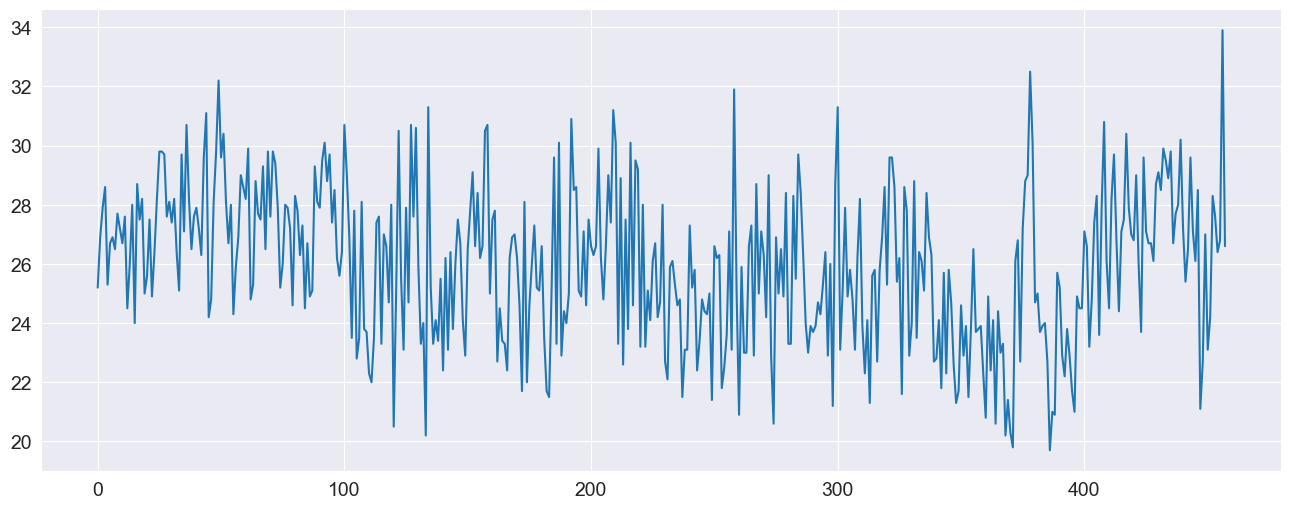

In [298]:
data15.CUM_Steam.plot()

## QQ Plot

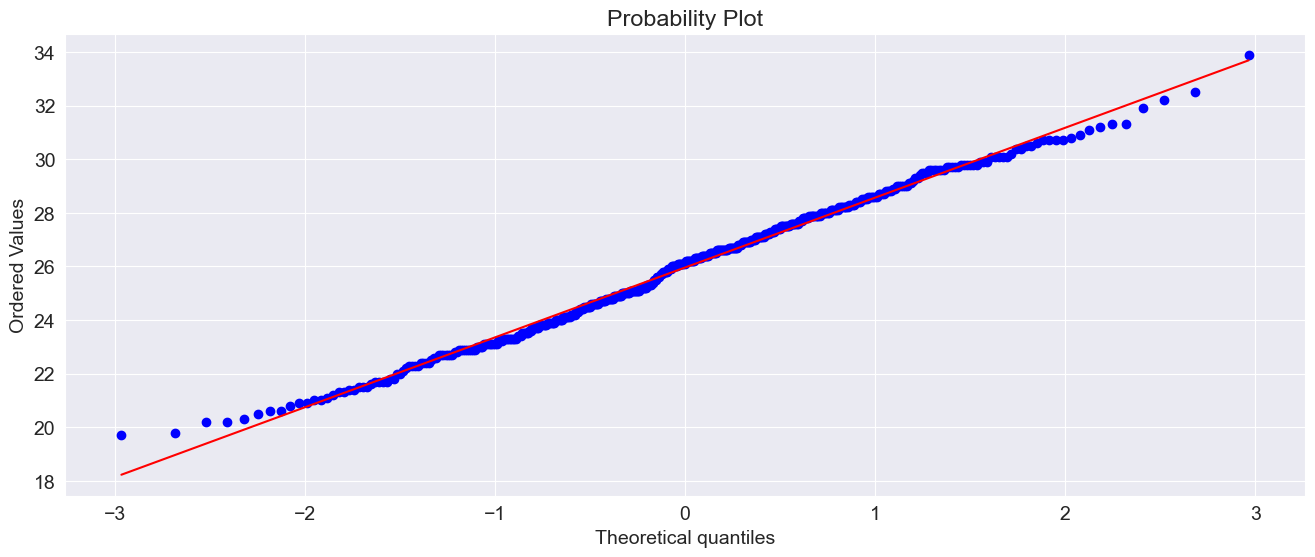

In [299]:
scipy.stats.probplot(data15.CUM_Steam, plot=pylab)
pylab.show()

In [300]:
# Create a range of integers representing the time axis from 0 to 500
time_axis = range(0, len(data15))  # Assuming inclusive range from 0 to 500

# Multiply each integer by 60 to convert it to minutes
minutes = [t * 60 for t in time_axis]

# Convert the minutes to datetime format with 1-minute frequency
time_index = pd.date_range(start='2023-01-01', periods=len(minutes), freq='T')

# Assign the datetime index to the DataFrame
data15.index = time_index

# Drop the existing 'time' column
data15.drop(columns=['BatchIndex'], inplace=True)

# Rename the index to 'time'
data15.index.name = 'Time'

# Drop the existing 'Time' column if needed
data15_comp = data15.copy()

In [301]:
data15.head()

,Delta,Damkohler,Sigma,CUM_Steam,Woodloading
Time,,,,,
2023-01-01 00:00:00,-0.260848,0.123912,0.937022,25.2,108.666275
2023-01-01 00:01:00,-0.344876,0.116629,1.033851,26.9,109.853065
2023-01-01 00:02:00,-0.339656,0.115659,1.027957,27.9,112.921150
2023-01-01 00:03:00,-0.317045,0.126365,0.993998,28.6,112.257874
2023-01-01 00:04:00,-0.284570,0.122794,0.971008,25.3,112.399788


In [302]:
data15_train = data15[:412]
data15_test = data15[412:417]

In [303]:
data15_train.tail()

,Delta,Damkohler,Sigma,CUM_Steam,Woodloading
Time,,,,,
2023-01-01 06:47:00,-0.214339,0.007323,1.014626,27.9,95.201584
2023-01-01 06:48:00,-0.583381,0.136749,1.215810,30.8,95.179120
2023-01-01 06:49:00,-0.359145,0.132851,1.018535,26.1,95.548090
2023-01-01 06:50:00,-0.212672,0.132671,0.838498,24.5,95.176450
2023-01-01 06:51:00,-0.233596,0.022933,1.026638,28.2,95.168365


In [304]:
data15_test.head

<bound method NDFrame.head of                         Delta  Damkohler     Sigma  CUM_Steam  Woodloading
Time                                                                      
2023-01-01 06:52:00 -0.279739   0.129834  0.958988       29.7    95.179190
2023-01-01 06:53:00 -0.262664   0.138864  0.924855       26.8    93.540530
2023-01-01 06:54:00 -0.270834   0.145218  0.930323       24.4    96.737830
2023-01-01 06:55:00 -0.335122   0.129122  1.005575       27.1    97.097946
2023-01-01 06:56:00 -0.349825   0.129506  1.015849       27.5   119.443611>

### Stationarity

In [305]:
sts.adfuller(data15_comp.CUM_Steam)

(-4.589252897357407,
 0.00013519121068810783,
 6,
 451,
 {'1%': -3.444932949082776,
  '5%': -2.867969899953726,
  '10%': -2.57019489663276},
 2018.1619851085152)

### ACF

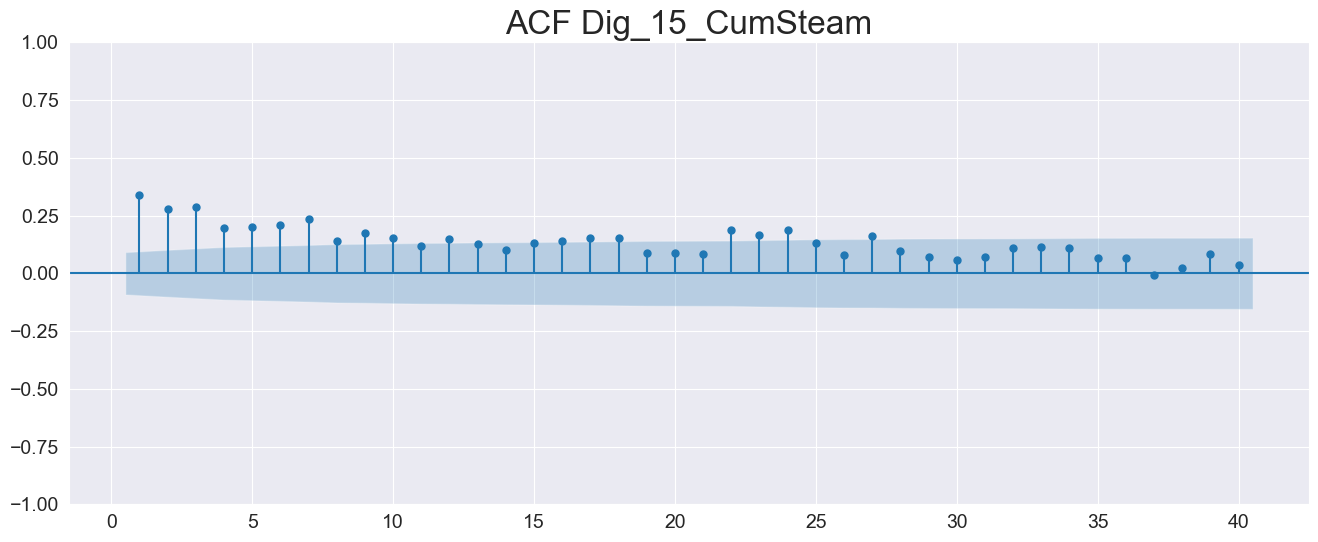

In [306]:
sgt.plot_acf(data15.CUM_Steam, lags = 40, zero = False)
plt.title("ACF Dig_15_CumSteam", size = 24)
plt.show()

### PACF

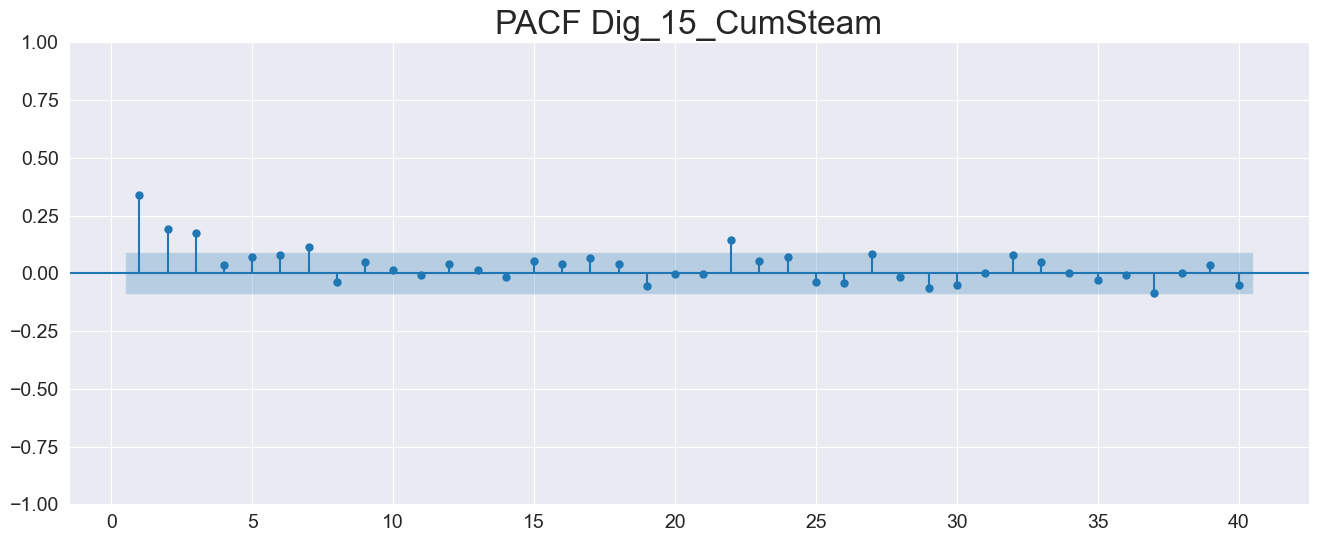

In [307]:
sgt.plot_pacf(data15.CUM_Steam, lags = 40, zero = False, method = ('ols'))
plt.title("PACF Dig_15_CumSteam", size = 24)
plt.show()

### ARIMA Models

In [308]:
model_arima = ARIMA(data15_train.CUM_Steam, order=(3, 1, 1))
results_arima = model_arima.fit()
print(results_arima.summary())

                               SARIMAX Results                                
Dep. Variable:              CUM_Steam   No. Observations:                  412
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -934.722
Date:                Thu, 28 Mar 2024   AIC                           1879.444
Time:                        20:40:45   BIC                           1899.537
Sample:                    01-01-2023   HQIC                          1887.393
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1777      0.048      3.677      0.000       0.083       0.272
ar.L2          0.1076      0.045      2.386      0.017       0.019       0.196
ar.L3          0.0945      0.053      1.794      0.0

### ARIMA311 Training Plots

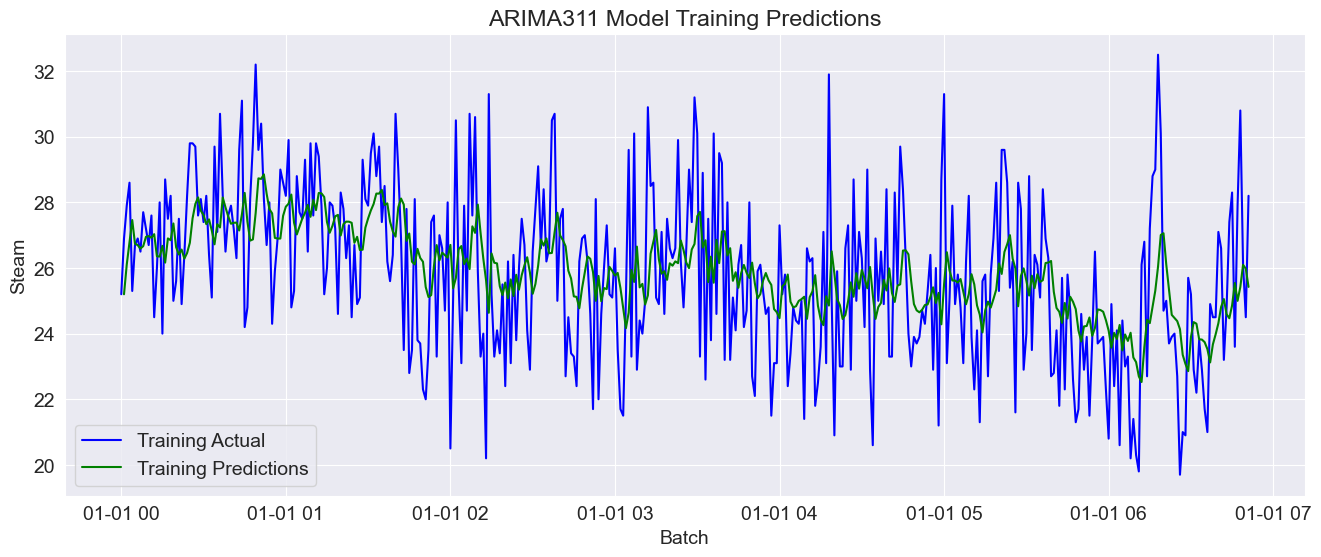

In [309]:
start_date = '2023-01-01 06:52:00'
end_date = '2023-01-01 06:56:00'

# Make predictions on training dataset
train_predictions = pd.DataFrame(results_arima.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
test_predictions = pd.DataFrame(results_arima.predict(start=start_date, end=end_date))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['CUM_Steam'], color='blue', label='Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='Training Predictions')

# Add labels and legend
plt.title('ARIMA311 Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### ARIMA311 Training Performance

In [310]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_train['CUM_Steam'], train_predictions['predicted_mean'])

print('rmse', rmse)
print('mae', mae)

rmse 2.6540662499358225
mae 1.980494912840921


### ARIMA311 Test Plots

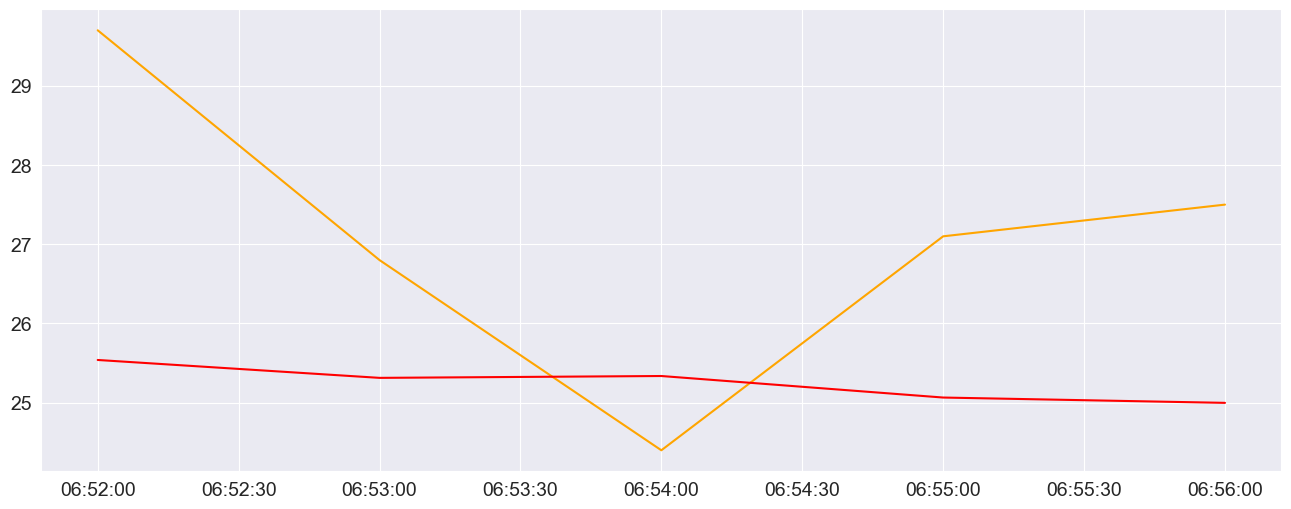

In [311]:
# Plot test data
plt.plot(data15_test.index, data15_test['CUM_Steam'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, test_predictions['predicted_mean'], color='red', label='Forecast')

# Show plot
plt.show()

### ARIMA311 Test Performance

In [312]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['CUM_Steam'], test_predictions['predicted_mean']))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['CUM_Steam'], test_predictions['predicted_mean'])

print('rmse', rmse)
print('mae', mae)

rmse 2.4816808250862694
mae 2.223990162126318


### ARIMAX With Woodload

In [313]:
# Define exogenous variables
exog_vars = data15_train[['Woodloading']]

# Fit AutoARIMA model with exogenous variables
model_arimax = ARIMA(data15_train['CUM_Steam'], exog=exog_vars, order=(3,1,1)) 
res_arimax = model_arimax.fit()
res_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              CUM_Steam   No. Observations:                  412
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -934.189
Date:                Thu, 28 Mar 2024   AIC                           1880.379
Time:                        20:40:54   BIC                           1904.490
Sample:                    01-01-2023   HQIC                          1889.917
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Woodloading    -0.0162      0.016     -1.011      0.312      -0.048       0.015
ar.L1           0.1722      0.049      3.526      0.000       0.076       0.268
ar.L2           0.1081      0.045      2.389      0.017       0.019       0.197
ar.L3           0.0873      0.053      1.645      0.100      -0.017       0.191
ma.L1          -0.9708      0.013    -74.199      0.000      -0.996      -0.945
sigma2          5.4901      0.436     12.594      0.000       4.636       6.345
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 5.70
Prob(Q):                              1.00   Prob(JB):                         0.06
Heteroskedasticity (H):               1.19   Skew:                             0.24
Prob(H) (two-sided):                  0.31   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMAX311 with Woodload Training Plots

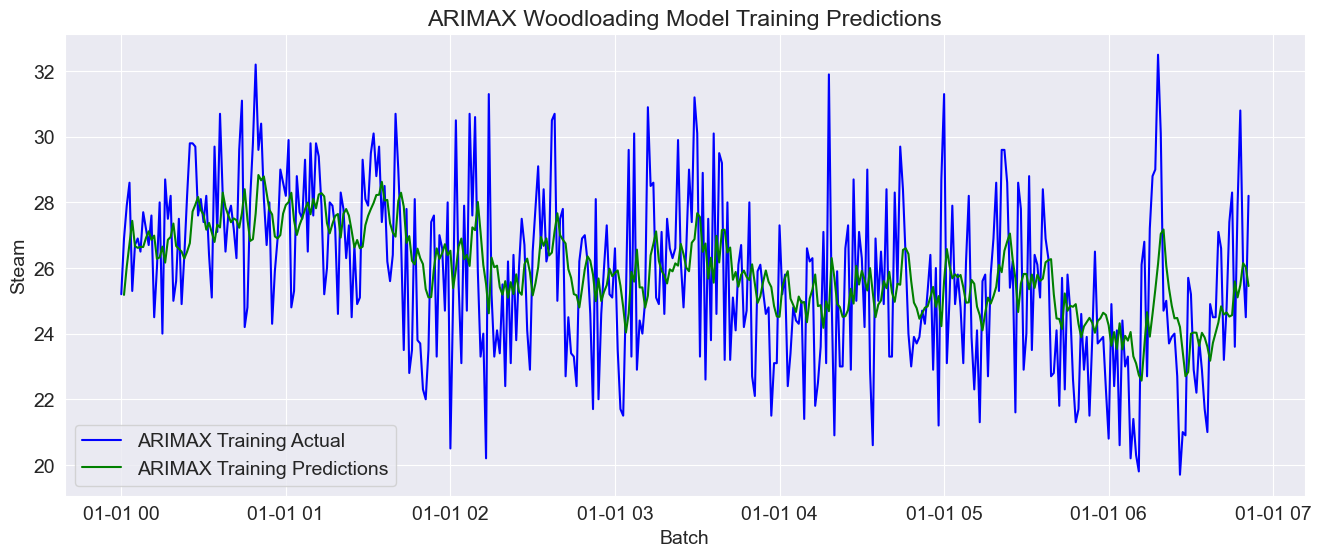

In [314]:
start_date = '2023-01-01 06:52:00'
end_date = '2023-01-01 06:56:00'
exog_vars_test = data15_test[['Woodloading']]

# Make predictions on training dataset
train_predictions = pd.DataFrame(res_arimax.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
arimax_test_predictions = pd.DataFrame(res_arimax.predict(start=start_date, end=end_date, exog=exog_vars_test))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['CUM_Steam'], color='blue', label='ARIMAX Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='ARIMAX Training Predictions')

# Add labels and legend
plt.title('ARIMAX Woodloading Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### ARIMAX311 Woodload Training Performance

In [315]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_train['CUM_Steam'], train_predictions['predicted_mean'])

print('rmse', rmse)
print('mae', mae)

rmse 2.6932895993583865
mae 1.9840274426608153


### ARIMAX with Woodload test plots

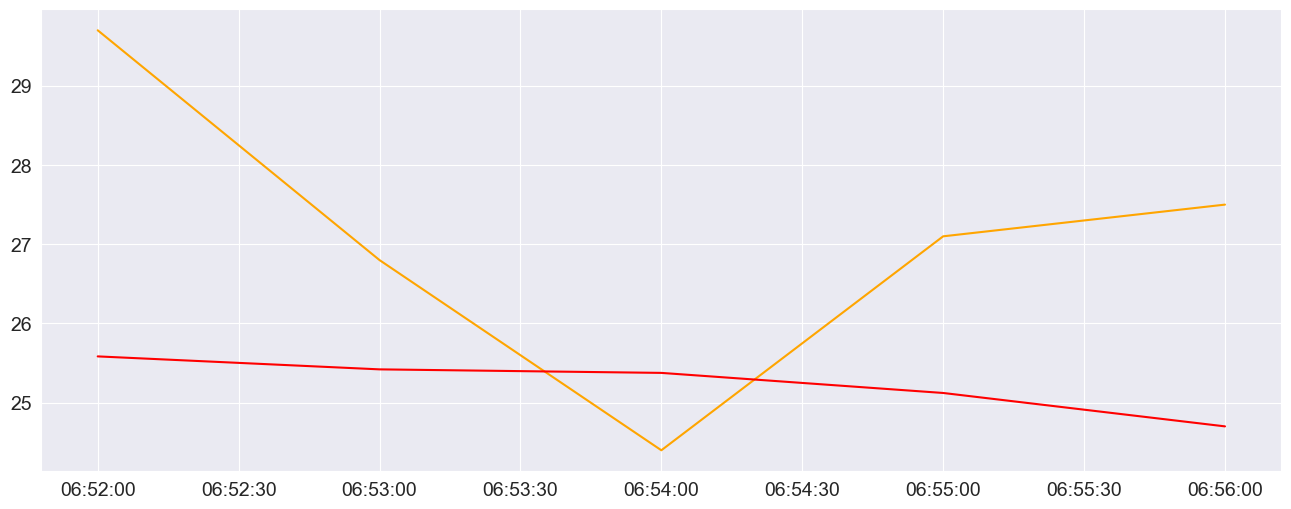

In [316]:
# Plot test data
plt.plot(data15_test.index, data15_test['CUM_Steam'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, arimax_test_predictions['predicted_mean'], color='red', label='Forecast')

# Show plot
plt.show()

### ARIMAX with Woodload test performance

In [317]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean']))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean'])

print('rmse', rmse)
print('mae', mae)

rmse 2.5111560848428236
mae 2.2491987714967534


### ARIMAX with all Parameters

In [318]:
# Define exogenous variables
exog_vars = data15_train[['Delta', 'Sigma']]

# Fit AutoARIMA model with exogenous variables
model_arimax = ARIMA(data15_train['CUM_Steam'], exog=exog_vars, order=(3,1,1)) 
res_arimax = model_arimax.fit()
res_arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              CUM_Steam   No. Observations:                  412
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -780.940
Date:                Thu, 28 Mar 2024   AIC                           1575.879
Time:                        20:41:04   BIC                           1604.010
Sample:                    01-01-2023   HQIC                          1587.007
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Delta         -1.7144      1.767     -0.970      0.332      -5.178       1.749
Sigma         14.4279      1.212     11.907      0.000      12.053      16.803
ar.L1          0.1395      0.053      2.655      0.008       0.037       0.242
ar.L2          0.1041      0.049      2.135      0.033       0.009       0.200
ar.L3          0.0327      0.052      0.626      0.531      -0.070       0.135
ma.L1         -0.9833      0.010    -97.399      0.000      -1.003      -0.964
sigma2         2.5997      0.203     12.811      0.000       2.202       2.997
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.93   Prob(JB):                         0.91
Heteroskedasticity (H):               0.88   Skew:                             0.02
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### ARIMAX311 with all parameters training plots

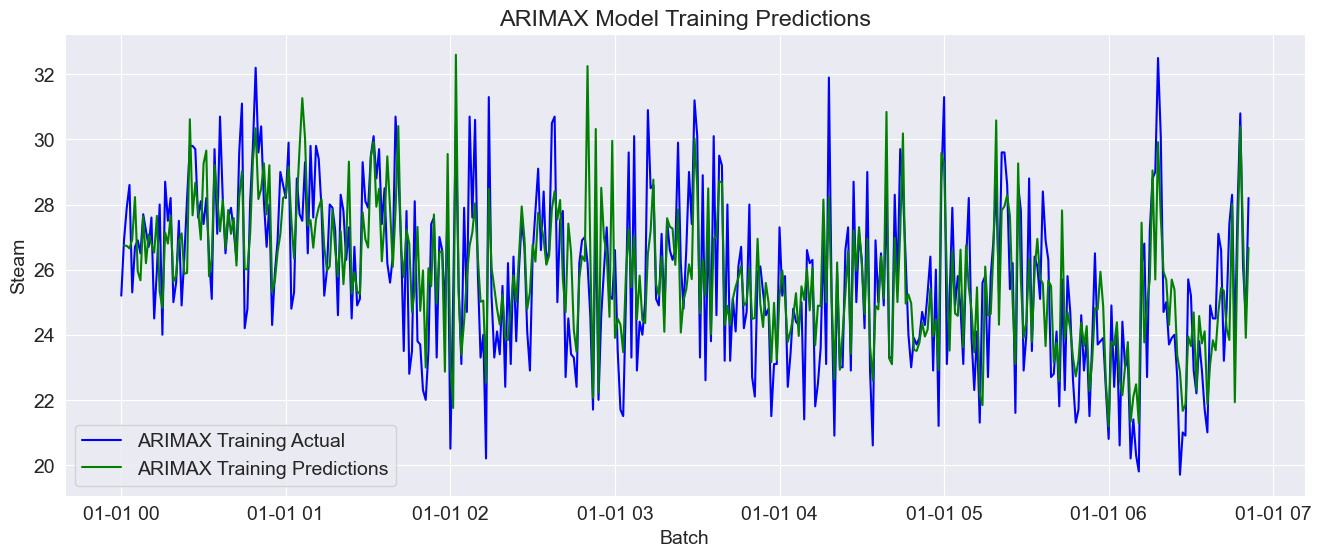

In [319]:
start_date = '2023-01-01 06:52:00'
end_date = '2023-01-01 06:56:00'
exog_vars_test = data15_test[['Delta', 'Sigma']]

# Make predictions on training dataset
train_predictions = pd.DataFrame(res_arimax.predict())
#print(train_predictions)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#Make predictions on test dataset
arimax_test_predictions = pd.DataFrame(res_arimax.predict(start=start_date, end=end_date, exog=exog_vars_test))
#print(test_predictions)

# Plot actual values of training data
plt.plot(data15_train.index, data15_train['CUM_Steam'], color='blue', label='ARIMAX Training Actual')

# Plot predicted values of training data
plt.plot(data15_train.index[1:], train_predictions['predicted_mean'].iloc[1:], color='green', label='ARIMAX Training Predictions')

# Add labels and legend
plt.title('ARIMAX Model Training Predictions')
plt.xlabel('Batch')
plt.ylabel('Steam')
plt.legend()

# Show plot
plt.show()

### Training Performance

In [320]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_train['CUM_Steam'], train_predictions['predicted_mean']))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_train['CUM_Steam'], train_predictions['predicted_mean'])

print('rmse', rmse)
print('mae', mae)

rmse 1.7058643937462428
mae 1.3214080226626983


### ARIMAX test plots

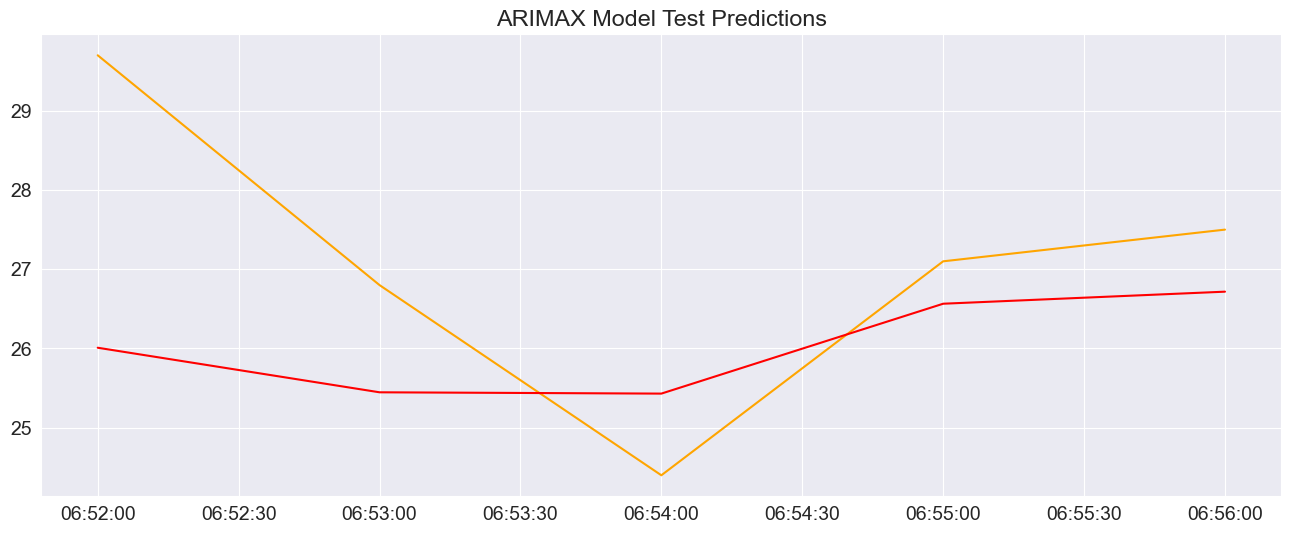

In [321]:
# Plot test data
plt.plot(data15_test.index, data15_test['CUM_Steam'], color='orange', label='Test')

# Plot forecasted values of test data
plt.plot(data15_test.index, arimax_test_predictions['predicted_mean'], color='red', label='Forecast')

# Add labels and legend
plt.title('ARIMAX Model Test Predictions')

# Show plot
plt.show()

In [322]:
residuals = data15_train['CUM_Steam'] - train_predictions['predicted_mean']

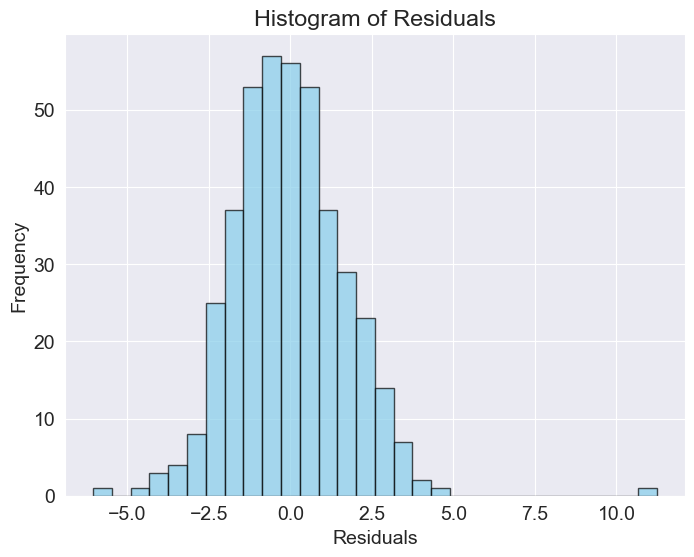

In [323]:
# Create a histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

# Add a grid for better visualization
plt.grid(True)

# Show plot
plt.show()

### Test Performance

In [324]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean']))

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(data15_test['CUM_Steam'], arimax_test_predictions['predicted_mean'])

print('rmse', rmse)
print('mae', mae)

rmse 1.8660941549026913
mae 1.478439900146494
